# Выявление особенностей словоупотребления в текстах Л. Н. Толстого методами дистрибутивной семантики

** TO DO **

- обучить сегментатор поточнее

In [1]:
import os
import re

In [ ]:
from lxml import etree
from pymystem3 import Mystem
import string
import nltk
from datetime import datetime
mystem = Mystem()

In [2]:
from numpy import nan
import numpy as np
import pandas as pd
from random import sample
from sklearn.metrics import accuracy_score

In [3]:
from scipy.stats import kendalltau, spearmanr,pearsonr

In [4]:
import gensim

C:\Users\Glaz\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline  

## Сегментатор

In [5]:
language_punkt_vars = nltk.tokenize.punkt.PunktLanguageVars
language_punkt_vars.sent_end_chars=('.','?','!','»','…')
with open('.\\data\\traindata.txt', 'r', encoding='utf-8') as f:
    traindata = f.read()
trainer = nltk.tokenize.punkt.PunktTrainer(traindata, language_punkt_vars)
trainer.INCLUDE_ALL_COLLOCS = True 
trainer.INCLUDE_ABBREV_COLLOCS = True
params = trainer.get_params()
sbd = nltk.tokenize.punkt.PunktSentenceTokenizer(params)

  Abbreviation: [1.4849] ст
  Abbreviation: [4.0363] н
  Abbreviation: [1.4849] ул
  Abbreviation: [8.0726] м
  Abbreviation: [5.4625] тыс
  Abbreviation: [5.9395] т.п
  Abbreviation: [19.3033] см
  Abbreviation: [0.5463] стр
  Abbreviation: [1.4849] кн
  Abbreviation: [4.0363] д
  Abbreviation: [1.0925] руб
  Abbreviation: [4.0363] п
  Abbreviation: [0.6029] матф
  Abbreviation: [4.0363] г
0.000380517503805175 0.007662835249042145 0.0 5256 261 2 2
0.000380517503805175 0.007662835249042145 0.0 5256 261 2 2
0.0030441400304414 0.007662835249042145 0.0028028028028028026 5256 261 16 2
0.009512937595129375 0.038314176245210725 0.008008008008008008 5256 261 50 10
0.0030441400304414 0.007662835249042145 0.0028028028028028026 5256 261 16 2
0.001141552511415525 0.007662835249042145 0.0008008008008008008 5256 261 6 2
0.0036149162861491627 0.007662835249042145 0.0034034034034034033 5256 261 19 2
0.00076103500761035 0.007662835249042145 0.0004004004004004004 5256 261 4 2
0.0015220700152207 0.02298

## Данные

На основе 90-томного собрания сочинений

Namespace тегов

In [6]:
tei_ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

Знаки пунктуации для удаления

In [7]:
string.punctuation = string.punctuation.replace('-','')
string.punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

## Функции предобработки

#### Функция для парсинга одного файла.

- ** Вход : ** имя файла
- ** Дополлнительные сведения : ** теги для удаления и исключения, пространство имен тегов получает из пространства имен (области видимости) выше по уровню
- ** Выход : ** нужный текст

In [8]:
def get_one_writing(filename):
    global tei_ns
    root = etree.parse(filename)#.getroot()
    for i in tags_for_deletion:
        for j in root.findall(i, tei_ns):
            parent = j.find("..")
            parent.remove(j)
    for i in tags_to_strip:
        etree.strip_tags(root, i)
    return root.find(".//tei:text", tei_ns).text.strip()

#### Функция для препроцессинга текста

- ** Вход : ** текст, файл записи
- ** Дополнительная информация : ** сегментатор, Mystem - глобальные переменные
- ** Выход : ** количество предложений (для вывода и отслеживания)


** Ход преобразований **

1. Исключение множественных пробелов и переносов строки
2. Деление на предложения
3. Объединение с разделителем в виде $$, так как mystem быстрее работает при одном вызове на большой файл, чем на маленьких частях. И такой знак не встречается в текстах
4. Удаляем [], в которых в текстах восстановлены сокращения
5. Лемматизируем с помощью mystem
6. Удаляем некириллические символы (удаляем нерусский текст, знаки препинания (кроме дефисов), оставляем наши разделители
7. Удаялем возможные множественные дефисы
8. Удаляем остатки от слов типа 8-го (-го).
9. Восстанавливаем разбиение на предложения
10. Если от строки осталось более 25 символов (удаляем слишком маленькие предложения и строки, которые у нас отделяются со ссылками типа (Лука, VII), то записываемв файл.

In [9]:
def preprocessing(text, f):
    global sbd, mystem
    text = re.sub('[\n\s]+',' ', text)
    lng = len(sbd.sentences_from_text(text, realign_boundaries=True))
    text = ' $$ '.join(sbd.sentences_from_text(text, realign_boundaries=True))
    text = text.replace('[','').replace(']','')
    text = ''.join(mystem.lemmatize(text.strip()))
    text = re.sub('[^а-яА-Я\-$ ]','', text)
    text = re.sub('[-]{2,}','', text)
    text = re.sub('[^а-яА-Я]-.*? ',' ', text)
    text = text.split('$$')
    for i in text:
        if len(i.strip())>25:
            f.write(i.strip()+'\n')
    return lng

In [10]:
with open ('1.txt', 'w') as f:
    preprocessing ('Я 1-го числа никак не приду к вам.\n\nЗасим удаляюсь.', f)

#### Функция объединяющая преобразования

- ** Вход : ** путь к папке с данными, тэги для удаления, теги для опущения, имя файла записи, параметр печати логов

** Печать **

- если установлен флажок печати, то печатает: количество предложений в тексте, размер файла (для проверки), время обработки файла, имя файла
- общее время работы

In [11]:
def universal_preprocessing(path, 
                            tags_for_deletion, 
                            tags_to_strip, 
                            filename, printing=True):
    #tags_for_deletion = tags_for_deletion
    #tags_to_strip = tags_to_strip
    #mystem = Mystem()
    start_gen = datetime.now()
    with open (filename, 'w', encoding='utf-8') as f:
        for root, dirs, files in os.walk (path):
                for fl in files :
                    start = datetime.now() 
                    lng = preprocessing(get_one_writing(root+'\\'+fl), f)
                    if printing:
                        print ('{}\t{}\t{}\t{}'.format(lng, os.path.getsize(root+'\\'+fl)//1024, 
                                              datetime.now()-start,
                                              fl))
    print ('\n\ntotal time:\t\t {}'.format(datetime.now()-start_gen))
    

### Произведения

Удаляем ненужные комментарии (заметки, пояснения, старые формы, где есть исправления, элементы таблицы). Убираем теги, которые не несут информации, чтобы объединить в единый массив текста.

In [12]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb']

НЕ ЗАПУСКАТЬ!!!

In [13]:
path = '.\\data\\Final\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'writings.txt')

938	125	0:00:02.182899	Abrégé de l’Evangile 24.xml
21	8	0:00:01.690339	AMOUR DE LA PATRIE 1.xml
70	37	0:00:01.979403	Carthago delenda est 39.xml
87	32	0:00:01.801238	Carthago delenda est. Черновое 39.xml
322	95	0:00:02.451469	Letter to a Hindoo (Письмо к индусу) 37.xml
44	13	0:00:01.980461	NOTES SUR LE SECOND CHAPITRE DES «CARACTÈRES» DE LA BRUYÈRE 1.xml
28	13	0:00:02.084049	The hostelry (Гостиница) 37.xml
19	19	0:00:02.041133	[Carthago delenda est] («Жизнь, та форма жизни»...) 27.xml
9	5	0:00:01.725240	[LE PRÉSENT, LE PASSÉ ET LE FUTUR] 1.xml
9	9	0:00:01.620498	[«Давно позабыл я о счастьи ...»] 1.xml
49	29	0:00:01.531272	[«Дядинька Жданов и кавалер Чернов»] 3.xml
60	42	0:00:01.624674	[«Ежели бы человек не желал…»] 1.xml
18	12	0:00:01.594855	[«Ей, Марьяна, брось работу!..»] 1.xml
37	22	0:00:01.562201	[«Знание музыки - субъективное и объективное...»] 1.xml
728	330	0:00:02.259206	[«Начала» романа «Сто лет»] 17.xml
370	203	0:00:02.007993	[«Начала» романа времен Петра I. Азовские походы] 1

### Письма

Добавляются теги <opener> и <closer> как элементы письма, которые не относятся к непосредственному текксту.

In [16]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table',
                      './/tei:opener', './/tei:closer']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb','{http://www.tei-c.org/ns/1.0}body']

In [17]:
path = '.\\data\\LETTERS\\'
for root, dirs, files in os.walk (path):
    for fl in files :
        with open (root+'\\'+fl, 'r', encoding='utf-8') as f:
            s = f.read()
            s = re.sub('<note.*?>', '<note>', s)
            s = re.sub('xml:id=".*?"','',s)
        with open (root+'\\'+fl,'w', encoding='utf-8') as f:
            f.write(s)

In [18]:
path = '.\\data\\LETTERS\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'letters.txt', printing=False)



total time:		 3:40:50.729214


### Дневники

In [14]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table', './/tei:opener']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb','{http://www.tei-c.org/ns/1.0}body']

In [15]:
path = '.\\data\\diaries\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'diaries.txt')

845	981	0:00:02.302519	46.xml
522	698	0:00:02.069947	47.xml
2673	268	0:00:02.784657	48.xml
4699	425	0:00:03.677143	49.xml
6190	778	0:00:05.672677	50.xml
3502	441	0:00:03.856642	51.xml
3827	612	0:00:04.726578	52.xml
4718	897	0:00:06.313160	53.xml
1582	752	0:00:03.274821	54.xml
2210	1117	0:00:03.734177	55.xml
2574	639	0:00:03.960775	56.xml
2833	733	0:00:03.887149	57.xml
2451	568	0:00:02.797811	58.xml


total time:		 0:00:49.060039


## Соединить источники

In [19]:
files = ['writings.txt', 'letters.txt', 'diaries.txt']
with open ('full_collection.txt', 'w',encoding = 'utf-8') as outp:
    for file in files:
        with open (file, 'r', encoding = 'utf-8') as inp:
            for line in inp:
                outp.write(line)

## Референтный корпус

In [23]:
path = '.\\data\\nkrya\\'
start_gen = datetime.now()
with open ('nkrya.txt', 'w', encoding='utf-8') as f:
    for root, dirs, files in os.walk (path):
        for fl in files :
            with open (root+'\\'+fl, 'r', encoding='utf-8') as inp:
                text = re.sub('\{.*?\}','', inp.read())
                lng = preprocessing(text, f)
print ('\n\ntotal time:\t\t {}'.format(datetime.now()-start_gen))



total time:		 3:03:55.088993


## Все модели

Так как данные имеют большой размер, подаем на вход объект, считываемыц из файла (с возможностью итерации без хранения в памяти)

In [2]:
sentences_tolstoy = gensim.models.word2vec.LineSentence('full_collection.txt')
sentences_nkrya = gensim.models.word2vec.LineSentence('nkrya.txt')

### Word2Vec

** CBOW **

In [4]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
Tolstoy_W2V_CBOW.save("./models/Tolstoy_W2V_CBOW.model")
print(Tolstoy_W2V_CBOW)

Word2Vec(vocab=33439, size=300, alpha=0.025)


In [5]:
NKRYA_W2V_CBOW = gensim.models.Word2Vec(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
NKRYA_W2V_CBOW.save("./models/NKRYA_W2V_CBOW.model")
print(NKRYA_W2V_CBOW)

Word2Vec(vocab=55217, size=300, alpha=0.025)


** Skipgram **

In [6]:
Tolstoy_W2V_SG = gensim.models.Word2Vec(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_W2V_SG.save("./models/Tolstoy_W2V_SG.model")
print(Tolstoy_W2V_SG)

Word2Vec(vocab=33439, size=300, alpha=0.025)


In [9]:
NKRYA_W2V_SG = gensim.models.Word2Vec(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_W2V_SG.save("./models/NKRYA_W2V_SG.model")
print(NKRYA_W2V_SG)

Word2Vec(vocab=55217, size=300, alpha=0.025)


### FastText

** CBOW **

In [10]:
Tolstoy_FT_CBOW = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
Tolstoy_FT_CBOW.save("./models/Tolstoy_FT_CBOW.model")
print(Tolstoy_FT_CBOW)

FastText(vocab=33439, size=300, alpha=0.025)


In [3]:
NKRYA_FT_CBOW = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
NKRYA_FT_CBOW.save("./models/NKRYA_FT_CBOW.model")
print(NKRYA_FT_CBOW)

FastText(vocab=55217, size=300, alpha=0.025)


** Skipgram **

In [12]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_FT_SG.save("./models/Tolstoy_FT_SG.model")
print(Tolstoy_FT_SG)

FastText(vocab=33439, size=300, alpha=0.025)


In [13]:
NKRYA_FT_SG = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_FT_SG.save("./models/NKRYA_FT_SG.model")
print(NKRYA_FT_SG)

FastText(vocab=55217, size=300, alpha=0.025)


** Загрузка всех моделей **

In [11]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_CBOW.model")
NKRYA_W2V_CBOW = gensim.models.Word2Vec.load("./models/NKRYA_W2V_CBOW.model")
Tolstoy_W2V_SG = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_SG.model")
NKRYA_W2V_SG = gensim.models.Word2Vec.load("./models/NKRYA_W2V_SG.model")

In [17]:
Tolstoy_FT_CBOW = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_CBOW.model")
NKRYA_FT_CBOW = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_CBOW.model")
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG.model")

In [12]:
Araneum_FT_CBOW = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextcbow_300_5_2018.model")
Araneum_FT_SG = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextskipgram_300_5_2018.model")

## Сравнение

### Simlex

In [5]:
simlex = pd.read_csv('./data/ru_simlex965.tsv', sep='\t')

In [6]:
simlex.columns = ['Word1','Word2','Score_SL']
simlex['Score_SL'].dtype

dtype('float64')

In [7]:
a = list(simlex['Word1'])
b = list(simlex['Word2'])
simlex_words = list(zip(a,b))

In [8]:
def model_result(words,model):
    try:
        result =  model.wv.similarity(words[0], words[1])
        return result
    except:
        return nan

In [ ]:
models = [Tolstoy_W2V_CBOW, NKRYA_W2V_CBOW, Tolstoy_W2V_SG, NKRYA_W2V_SG,
          Tolstoy_FT_CBOW, NKRYA_FT_CBOW, Tolstoy_FT_SG, NKRYA_FT_SG,
          Araneum_FT_CBOW, Araneum_FT_SG]
model_names = ['Tolstoy_W2V_CBOW', 'NKRYA_W2V_CBOW', 'Tolstoy_W2V_SG', 'NKRYA_W2V_SG',
          'Tolstoy_FT_CBOW', 'NKRYA_FT_CBOW', 'Tolstoy_FT_SG', 'NKRYA_FT_SG',
          'Araneum_FT_CBOW', 'Araneum_FT_SG']
all_models = list(zip(models,model_names))

In [14]:
all_models

[(<gensim.models.word2vec.Word2Vec at 0x23487a10fd0>, 'Tolstoy_W2V_CBOW'),
 (<gensim.models.word2vec.Word2Vec at 0x2348a6744a8>, 'NKRYA_W2V_CBOW'),
 (<gensim.models.word2vec.Word2Vec at 0x234923fdcc0>, 'Tolstoy_W2V_SG'),
 (<gensim.models.word2vec.Word2Vec at 0x234923fdeb8>, 'NKRYA_W2V_SG'),
 (<gensim.models.fasttext.FastText at 0x23487a20550>, 'Tolstoy_FT_CBOW'),
 (<gensim.models.fasttext.FastText at 0x234923fddd8>, 'NKRYA_FT_CBOW'),
 (<gensim.models.fasttext.FastText at 0x234a113c860>, 'Tolstoy_FT_SG'),
 (<gensim.models.fasttext.FastText at 0x234a113c710>, 'NKRYA_FT_SG'),
 (<gensim.models.fasttext.FastText at 0x2348a5212b0>, 'Araneum_FT_CBOW'),
 (<gensim.models.fasttext.FastText at 0x235e57cd128>, 'Araneum_FT_SG')]

In [13]:
for i in all_models:
    simlex[i[1]] = np.apply_along_axis(model_result, 1, arr = simlex_words, model = i[0] )

In [14]:
simlex.head()

,Word1,Word2,Score_SL,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,авария,бедствие,6.15,0.315040,0.312024,0.458422,0.383732,0.366403,0.401920,0.387836,0.423720,0.417583,0.532138
1,август,месяц,2.85,0.517988,0.390630,0.473710,0.403803,0.552756,0.394618,0.513207,0.400371,0.365336,0.538927
2,авиация,полет,6.77,NaN,NaN,NaN,NaN,0.315683,0.418777,0.336305,0.353902,0.369196,0.480803
3,автомобиль,гудок,1.85,NaN,NaN,NaN,NaN,0.309600,0.287628,0.541232,0.209126,0.052265,0.259283
4,автомобиль,автострада,1.23,NaN,NaN,NaN,NaN,0.287549,0.612199,0.642494,0.515194,0.521806,0.449036


In [15]:
simlex_short = simlex.dropna()

In [17]:
for i in all_models:
    print ('{}\t\t{}'.format(i[1], spearmanr(simlex_short[i[1]], simlex_short['Score_SL'])[0]))

Tolstoy_W2V_CBOW		-0.02312097810078662
NKRYA_W2V_CBOW		0.2728283340461548
Tolstoy_W2V_SG		0.13547678929311274
NKRYA_W2V_SG		0.3180245293198616
Tolstoy_FT_CBOW		0.10480719946239418
NKRYA_FT_CBOW		0.24098530695427278
Tolstoy_FT_SG		0.15588363327276267
NKRYA_FT_SG		0.27768484342806704
Araneum_FT_CBOW		0.3220139240500222
Araneum_FT_SG		0.3263901137902892


** Пропорции **

** семья **

In [18]:
family = pd.read_csv('./data/ru_analogy_family.txt', sep=' ', header=None)
family.columns = ['Word1','Word2','Word3','Result']

In [19]:
family.head()

,Word1,Word2,Word3,Result
0,мальчик,девочка,брат,сестра
1,мальчик,девочка,братья,сестры
2,мальчик,девочка,папа,мама
3,мальчик,девочка,отец,мать
4,мальчик,девочка,дед,бабка


In [20]:
a = list(family['Word1'])
b = list(family['Word2'])
c = list(family['Word3'])
family_words = list(zip(a,b,c))

In [21]:
def proportion(words,model):
    #print (words)
    try:
        result = model.wv.most_similar(positive=[words[0], words[1]], negative=[words[2]])[0][0]
        return result
    except:
        return nan

In [22]:
for i in all_models:
    family[i[1]] = [proportion(words, i[0]) for words in family_words]

In [25]:
family.head(5)

,Word1,Word2,Word3,Result,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,мальчик,девочка,брат,сестра,кукла,мальчуган,девушка,девушка,девчонка,мальчишечка,кмальчик,девочка-подросток,пай-девочка,девчушка
1,мальчик,девочка,братья,сестры,девушка,мальчуган,девушка,мальчуган,кмальчик,мальчишечка,кмальчик,девочка-подросток,мальчонка,малышка
2,мальчик,девочка,папа,мама,юноша,мальчуган,двойня,мальчуган,мальчик-сын,мальчонка,кмальчик,девочка-подросток,мальчонка,девчушка
3,мальчик,девочка,отец,мать,баба,мальчуган,девушка,мальчуган,девчонка,мальчишечка,кмальчик,мальчишечка,пай-девочка,девчушка
4,мальчик,девочка,дед,бабка,девушка,мальчуган,девушка,девушка,мальчишка,мальчишечка,кмальчик,мальчишечка,пай-девочка,малышка


In [30]:
for i in all_models:
    print (i[1], '\t', accuracy_score(list(family['Result']),list(family[i[1]])))

Tolstoy_W2V_CBOW 	 0.0
NKRYA_W2V_CBOW 	 0.003952569169960474
Tolstoy_W2V_SG 	 0.0
NKRYA_W2V_SG 	 0.005928853754940711
Tolstoy_FT_CBOW 	 0.0
NKRYA_FT_CBOW 	 0.0
Tolstoy_FT_SG 	 0.0
NKRYA_FT_SG 	 0.0
Araneum_FT_CBOW 	 0.0
Araneum_FT_SG 	 0.0


** Прилагательные/наречия **

In [31]:
adj_adv = pd.read_csv('./data/ru_analogy_adj-adv.txt', sep=' ', header=None)
adj_adv.columns = ['Word1','Word2','Word3','Result']

In [32]:
a = list(adj_adv['Word1'])
b = list(adj_adv['Word2'])
c = list(adj_adv['Word3'])
adj_adv_words = list(zip(a,b,c))

In [33]:
for i in all_models:
    adj_adv[i[1]] = [proportion(words, i[0]) for words in adj_adv_words]

In [34]:
adj_adv.head(5)

,Word1,Word2,Word3,Result,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,удивительный,удивительно,очевидный,очевидно,ах,чудно,прелестный,прелестно,презрительно,неудивительный,неудивительный,неудивительный,необыкновенно,необыкновенно
1,удивительный,удивительно,спокойный,спокойно,глупо,замечательный,неважно,замечательный,значительно,неудивительный,неудивительный,неудивительный,поразительно,поразительный
2,удивительный,удивительно,веселый,весело,доказываться,поразительный,гадание,изумительный,неосновательно,неудивительный,неудивительный,неудивительный,поразительный,поразительный
3,удивительный,удивительно,страшный,страшно,умно,замечательно,умно,замечательно,одобрительно,замечательно,неудивительный,неудивительный,необычайно,необыкновенно
4,удивительный,удивительно,эффективный,эффективно,NaN,NaN,NaN,NaN,неудивительный,неудивительный,неудивительный,неудивительный,необыкновенно,необыкновенный


In [41]:
for i in all_models:
    print (i[1], '\t', accuracy_score(list(adj_adv['Result']),list(adj_adv[i[1]])))

Tolstoy_W2V_CBOW 	 0.00221606648199446
NKRYA_W2V_CBOW 	 0.000554016620498615
Tolstoy_W2V_SG 	 0.00110803324099723
NKRYA_W2V_SG 	 0.000554016620498615
Tolstoy_FT_CBOW 	 0.000554016620498615
NKRYA_FT_CBOW 	 0.000554016620498615
Tolstoy_FT_SG 	 0.000554016620498615
NKRYA_FT_SG 	 0.00110803324099723
Araneum_FT_CBOW 	 0.000554016620498615
Araneum_FT_SG 	 0.0016620498614958448


## Первый способ : искуственные сдвиги

Для оценки того, что является сдвигом, нужно создать его контролируемо и посмотреть на то, как он будет выглядеть. Нужно определить, какая метрика лучше отражает сдвиг, то есть будет коррелировать с тем, в какой степени мы изменили значение. Для этого заменим часть слов на сходные по частоте.

In [5]:
freq = pd.read_csv('./data/freqrnc2011.csv', sep='\t')

In [6]:
freq.columns = ['Lemma','PoS','Freq','R','D','Doc']

In [7]:
freq.head()

,Lemma,PoS,Freq,R,D,Doc
0,а,conj,8198.0,100,97,32332
1,а,intj,19.8,99,90,757
2,а,part,6.1,59,79,128
3,а,s,2.7,59,85,160
4,аа,intj,1.5,47,80,68


In [8]:
freq.shape

(52138, 6)

In [9]:
freq[freq.Freq > 100].shape

(1235, 6)

In [10]:
freq = freq[(freq.Freq > 100) & (freq.Freq < 1000)]
freq.shape

(1145, 6)

In [11]:
freq.head()

,Lemma,PoS,Freq,R,D,Doc
192,автомобиль,s,156.9,100,92,3453
207,автор,s,262.1,100,93,6216
462,акт,s,113.6,99,84,2830
465,актер,s,114.4,99,87,1827
533,Александр,s.PROP,237.8,100,91,6592


In [12]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_CBOW.model")
NKRYA_W2V_CBOW = gensim.models.Word2Vec.load("./models/NKRYA_W2V_CBOW.model")
Araneum_FT_CBOW = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextcbow_300_5_2018.model")

In [13]:
vocab = list(set(Tolstoy_W2V_CBOW.wv.vocab) & set(NKRYA_W2V_CBOW.wv.vocab) & set(Araneum_FT_CBOW.wv.vocab) & set(freq['Lemma']))

In [14]:
len(vocab)

934

In [15]:
a = [1,2,3,4,5,6,7,8,9,10]
a[:6:-1]

[10, 9, 8]

In [16]:
word_list = sample(vocab, 600)

In [17]:
list(reversed([1,2,3]))

[3, 2, 1]

In [18]:
Artificial_shifts =pd.DataFrame({
    'Lemma':word_list,
    'Lemma2':list(reversed(word_list[:200]))+list(reversed(word_list[200:400]))+list(reversed(word_list[400:600])), 
    'Q':[0.9]*200+[0.7]*200+[0.5]*200})

In [19]:
Artificial_shifts.head()

,Lemma,Lemma2,Q
0,нога,подходить,0.9
1,страх,тело,0.9
2,хозяин,против,0.9
3,ставить,использовать,0.9
4,нормальный,голос,0.9


In [20]:
Artificial_shifts.to_csv('./data/art_shifts.csv', sep='\t', index=False, encoding='utf-8')

Загружаем

In [31]:
Artificial_shifts = pd.read_csv('./data/art_shifts.csv', sep='\t', encoding='utf-8')

In [32]:
Artificial_shifts = Artificial_shifts.set_index('Lemma')

In [38]:
Artificial_shifts['target'] = Artificial_shifts['Q']*10

Artificial_shifts['T_counter'] = [0]*600
Artificial_shifts['T_changed'] = [0]*600
Artificial_shifts['T_total'] = [0]*600

Artificial_shifts['19_counter'] = [0]*600
Artificial_shifts['19_changed'] = [0]*600
Artificial_shifts['19_total'] = [0]*600

In [60]:
10 > 9.0

True

In [34]:
lemma = set(Artificial_shifts.index)

In [55]:
5 // 2

2

In [39]:
with open ('full_collection.txt', 'r', encoding = 'utf-8') as inp:
    with open ('full_collection_shift.txt', 'w', encoding = 'utf-8') as outp:
        for line in inp:
            unchanged = line.strip().split()
            changed = []
            for i in unchanged:
                if i in lemma:
                    change = Artificial_shifts['Lemma2'][i]
                    if Artificial_shifts['T_counter'][i] % 10 >= Artificial_shifts['target'][i]:               
                        changed.append(change)
                        Artificial_shifts.set_value(i, 'T_counter', Artificial_shifts['T_counter'][i] + 1)
                        Artificial_shifts.set_value(i, 'T_changed', Artificial_shifts['T_changed'][i] + 1)
                        #if Artificial_shifts['counter'][i] == 10:
                        #    Artificial_shifts.set_value(i, 'counter', 0) 
                    else:
                        changed.append(i)
                        Artificial_shifts.set_value(i, 'T_counter', Artificial_shifts['T_counter'][i] + 1)
                    Artificial_shifts.set_value(i, 'T_total', Artificial_shifts['T_total'][i] + 1)
                else:
                    changed.append(i)
            outp.write(' '.join(changed)+'\n')

In [42]:
Artificial_shifts['T'] = 1 - Artificial_shifts['T_changed']/Artificial_shifts['T_total']

In [44]:
Artificial_shifts[['Q','T']].corr()

,Q,T
Q,1.000000,0.972824
T,0.972824,1.000000


In [45]:
with open ('nkrya.txt', 'r', encoding = 'utf-8') as inp:
    with open ('nkrya_shift.txt', 'w', encoding = 'utf-8') as outp:
        for line in inp:
            unchanged = line.strip().split()
            changed = []
            for i in unchanged:
                if i in lemma:
                    change = Artificial_shifts['Lemma2'][i]
                    if Artificial_shifts['19_counter'][i] % 10 >= Artificial_shifts['target'][i]:               
                        changed.append(change)
                        Artificial_shifts.set_value(i, '19_counter', Artificial_shifts['19_counter'][i] + 1)
                        Artificial_shifts.set_value(i, '19_changed', Artificial_shifts['19_changed'][i] + 1)
                    else:
                        changed.append(i)
                        Artificial_shifts.set_value(i, '19_counter', Artificial_shifts['19_counter'][i] + 1)
                    Artificial_shifts.set_value(i, '19_total', Artificial_shifts['19_total'][i] + 1)
                else:
                    changed.append(i)
            outp.write(' '.join(changed)+'\n')

In [46]:
Artificial_shifts['19'] = 1 - Artificial_shifts['19_changed']/Artificial_shifts['19_total']

In [47]:
Artificial_shifts[['Q','19']].corr()

,Q,19
Q,1.000000,0.999978
19,0.999978,1.000000


In [48]:
Artificial_shifts.to_csv('./data/new_art.csv', sep='\t', index=False, encoding='utf-8')

### Обучим модели и сравним

In [49]:
sentences_tolstoy = gensim.models.word2vec.LineSentence('full_collection_shift.txt')
sentences_nkrya = gensim.models.word2vec.LineSentence('nkrya_shift.txt')

In [50]:
Tolstoy_FT_SG_shift = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_FT_SG_shift.save("./models/Tolstoy_FT_SG_shift.model")
print(Tolstoy_FT_SG_shift)

FastText(vocab=33439, size=300, alpha=0.025)


In [51]:
NKRYA_FT_SG_shift = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_FT_SG_shift.save("./models/NKRYA_FT_SG_shift.model")
print(NKRYA_FT_SG_shift)

FastText(vocab=55217, size=300, alpha=0.025)


In [6]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG.model")
Tolstoy_FT_SG_shift = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG_shift.model")
NKRYA_FT_SG_shift = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG_shift.model")

### Метрики

In [52]:
def Kendall(word, model1, model2, topn=50):
    one = model1.wv.most_similar(word, topn = topn)
    a = list(zip(*one))[1]
    words = list(zip(*one))[0]
    b = []
    if word in model2.wv.vocab:
        ref = {value[0]:key for key, value in enumerate(model2.wv.most_similar(word, topn = topn))}
        for i in words:
            if i in ref:
                b.append(ref[i])
            else:
                b.append(0)
        #a = list(a)
        result = kendalltau(list(range(0, topn)), b)[0]
        return result
    else:
        return 0

In [8]:
def Jaccard(word, model1, model2, topn=50):
    try:
        a = model1.wv.most_similar(word, topn = topn)
        b = model2.wv.most_similar(word, topn = topn)
        a = set(list(zip(*a))[0])
        b = set(list(zip(*b))[0])
        return len(a&b) / len (a)
    except:
        pass

** NDCG **

In [53]:
import math
def find_dcg(element_list):
    """
    Reference : https://github.com/dkaterenchuk/ranking_measures/
    Discounted Cumulative Gain (DCG)
    Parameters:
        element_list - a list of ranks Ex: [5,4,2,2,1]
    """
    score = 0.0
    for order, rank in enumerate(element_list):
        score += float(rank)/math.log((order+2))
    return score


def find_ndcg(reference, hypothesis):
    """
    Reference : https://github.com/dkaterenchuk/ranking_measures/
    Parameters:
        reference   - a gold standard (perfect) ordering Ex: [5,4,3,2,1]
        hypothesis  - a proposed ordering Ex: [5,2,2,3,1]
    Returns:
        ndcg_score  - normalized score
    """

    return find_dcg(hypothesis)/find_dcg(reference)

#def get_new_scores(word, model1, model2, topn):
#    one = model1.wv.most_similar(word, topn = topn)
#    a = list(zip(*one))[1]
#    words = list(zip(*one))[0]
#    b = []
#    for i in words:
#        try:
#            b.append(model2.wv.similarity(word, i))
#        except:
#            b.append(0)
#    a = list(a)
#    result = find_ndcg(a,b)
#    return result

def get_new_scores(word, model1, model2, topn=50):
    one = model1.wv.most_similar(word, topn = topn)
    a = list(zip(*one))[1]
    words = list(zip(*one))[0]
    b = []
    if word in model2.wv.vocab:
        ref = {value[0]:topn-key for key, value in enumerate(model2.wv.most_similar(word, topn = topn))}
        for i in words:
            if i in ref:
                b.append(ref[i])
            else:
                b.append(0)
        #a = list(a)
        result = find_ndcg(list(range(topn, 0, -1)), b)
        return result
    else:
        return 0

In [38]:
list(range(5, 0, -1))

[5, 4, 3, 2, 1]

### Check

In [10]:
Artificial_shifts = pd.read_csv('./data/art_shifts.csv', sep='\t', encoding='utf-8')

In [54]:
Kendall_vec = np.vectorize(Kendall)
Jaccard_vec = np.vectorize(Jaccard)
ndcg_vec = np.vectorize(get_new_scores)

In [34]:
Artificial_shifts['T_Kendall'] = Kendall_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift)
Artificial_shifts['T_Jaccard'] = Jaccard_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift)
Artificial_shifts['T_NDCG'] = ndcg_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift)

Artificial_shifts['19_Kendall'] = Kendall_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift)
Artificial_shifts['19_Jaccard'] = Jaccard_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift)
Artificial_shifts['19_NDCG'] = ndcg_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift)

гораздо


In [13]:
data = Artificial_shifts[['Q', 'T_Kendall','T_Jaccard','T_NDCG']]
data.corr(method='pearson')

,Q,T_Kendall,T_Jaccard,T_NDCG
Q,1.000000,0.357273,0.377068,0.363638
T_Kendall,0.357273,1.000000,0.775685,0.658651
T_Jaccard,0.377068,0.775685,1.000000,0.966708
T_NDCG,0.363638,0.658651,0.966708,1.000000


In [14]:
data = Artificial_shifts[['Q', '19_Kendall','19_Jaccard','19_NDCG']]
data.corr(method='pearson')

,Q,19_Kendall,19_Jaccard,19_NDCG
Q,1.000000,0.371406,0.439792,0.446724
19_Kendall,0.371406,1.000000,0.761347,0.655114
19_Jaccard,0.439792,0.761347,1.000000,0.969300
19_NDCG,0.446724,0.655114,0.969300,1.000000


In [135]:
pearsonr(Kendall_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 10),
             Artificial_shifts['Q'].values)[0]

C:\Users\Glaz\Anaconda3\lib\site-packages\scipy\stats\stats.py:5240: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


nan

In [15]:
print ('N\tJaccard\t\t\t\tNDCG')
for i in range(10,301,20):
    print ('{}\t{}\t{}'.format(i, 
    pearsonr(Jaccard_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0],
    pearsonr(ndcg_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0]))

N	Jaccard				NDCG
10	0.29782075502272337	0.31392269919399646
30	0.3598961763985644	0.3457975374194367
50	0.3770676293931677	0.36363774985751995
70	0.38777779387127465	0.374637144076195
90	0.39615528503063996	0.38092621017277095
110	0.4002304076346034	0.3847622525805162
130	0.3995006395317837	0.3871956301716254
150	0.4016454234745534	0.38867881807548615
170	0.4007496021370037	0.3894812804165459
190	0.39974096186160535	0.39027202846534514
210	0.4001084987534071	0.39182453763296554
230	0.40144979967805416	0.39317957054576586
250	0.39994043030012244	0.39335408993806437
270	0.39887427994026153	0.3931532429134164
290	0.3985238420829395	0.39325344726925354


In [19]:
print ('N\tJaccard\t\t\t\tNDCG')
for i in range(10,301,20):
    print ('{}\t{}\t{}'.format(i, 
    pearsonr(Jaccard_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0],
    pearsonr(ndcg_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0]))

N	Jaccard				NDCG
10	0.40478139078246184	0.45644207988987723
30	0.4312850331407627	0.4468233045341804
50	0.4397915135628914	0.4467235075664127
70	0.45284529964856407	0.4538915543855693
90	0.45146385517269827	0.4563756735976461
110	0.4545969067919166	0.45682862602393715
130	0.4614960891023907	0.4598484908150427
150	0.4686990854654992	0.46298506182234944
170	0.47123053450421304	0.4644426534426928
190	0.4726981056569187	0.46620949733012845
210	0.4698487174721982	0.46598106450917076
230	0.4706800702032965	0.46615184925387526
250	0.47369849649043055	0.4682715514827002
270	0.47425132805522824	0.46928854352967647
290	0.47198618197904857	0.4697938779295813


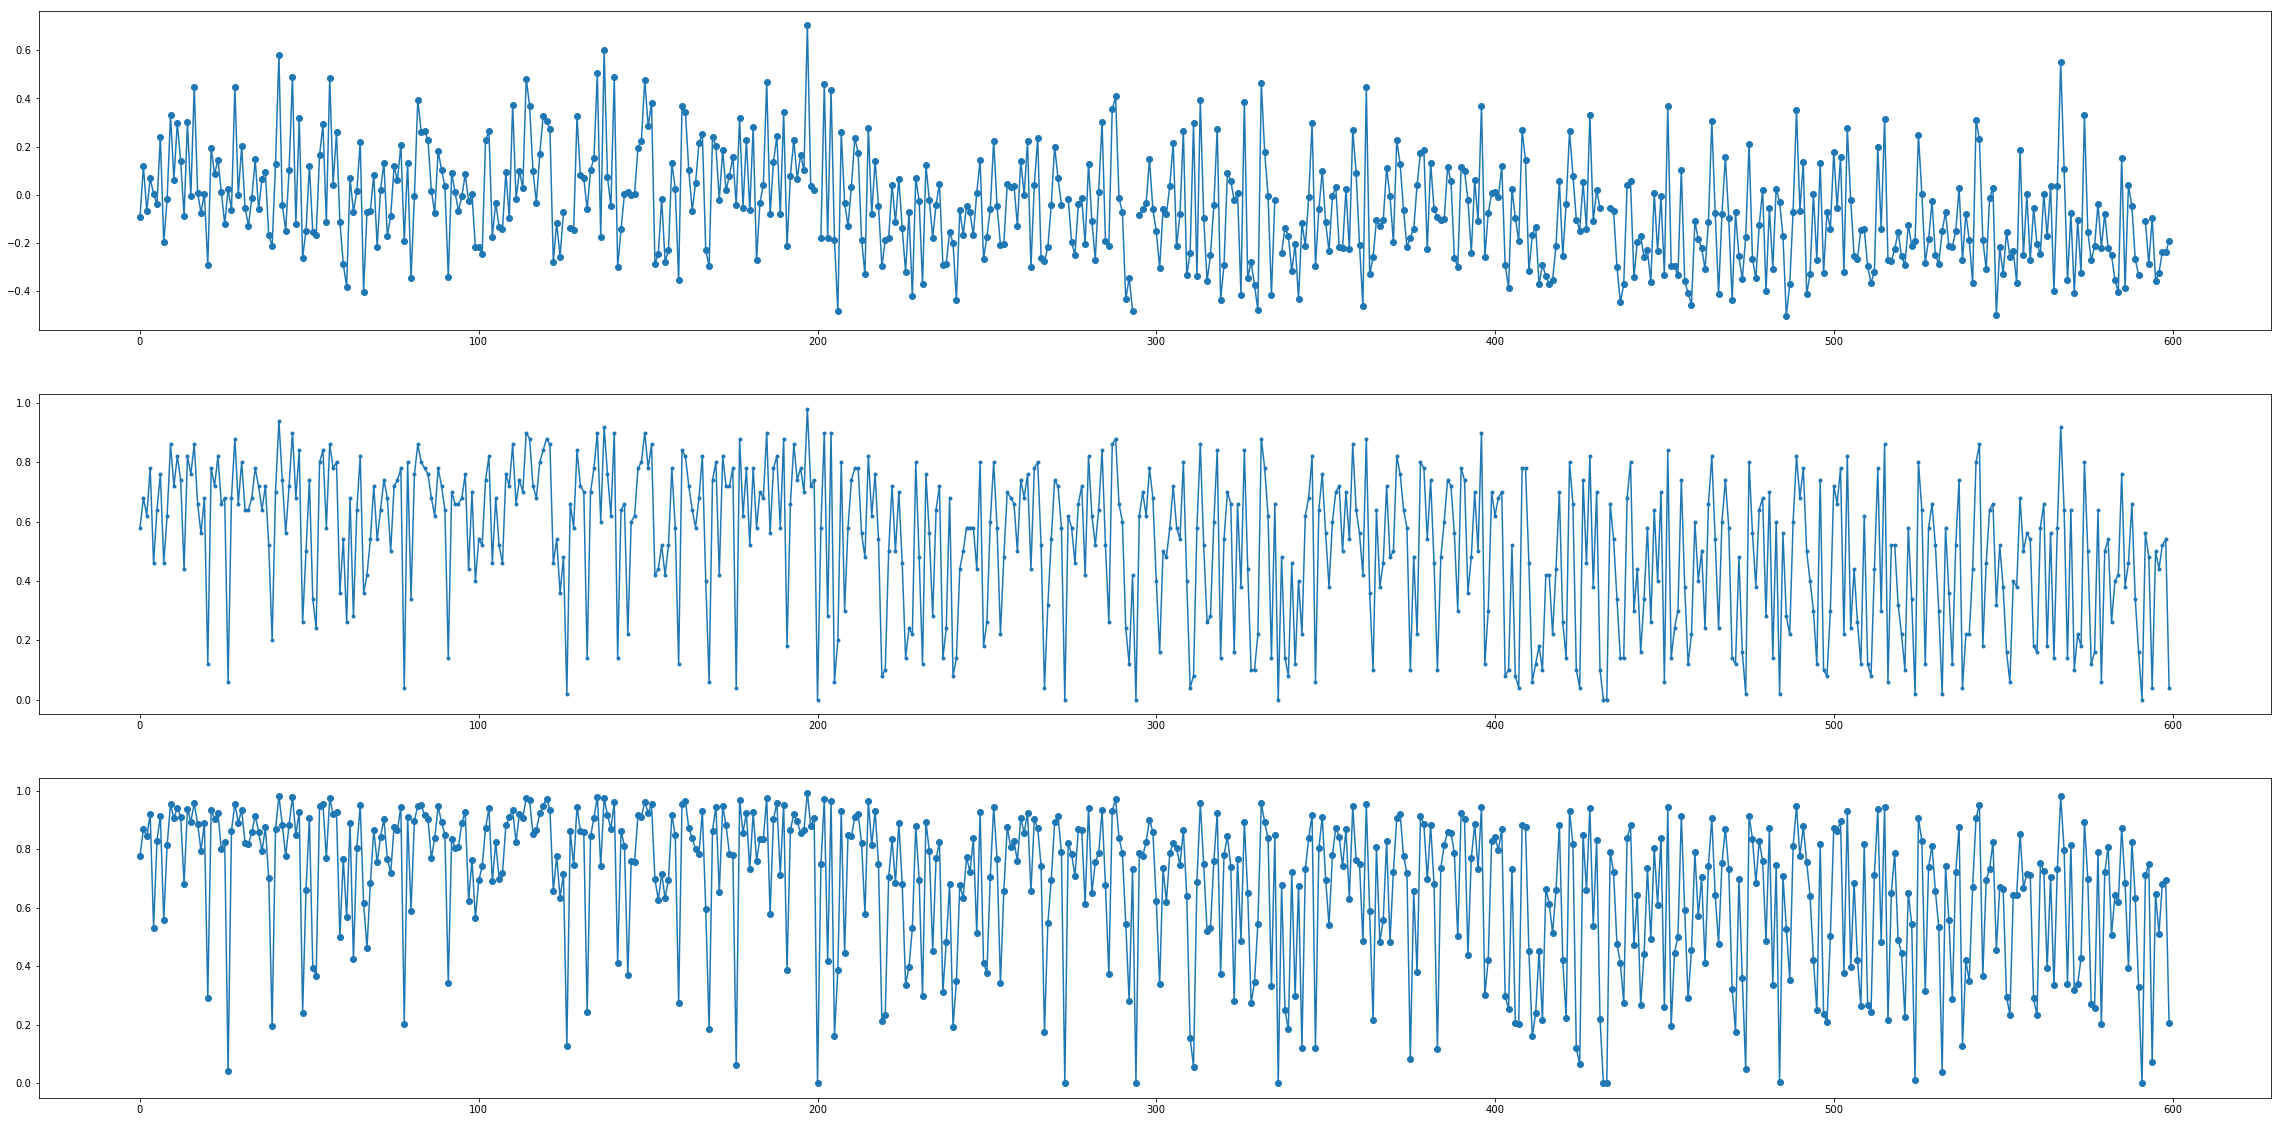

In [20]:
y1 = np.array(Artificial_shifts['T_Kendall'].values)
y2 = np.array(Artificial_shifts['T_Jaccard'].values)
y3 = np.array(Artificial_shifts['T_NDCG'].values)

x = list(range(600))
plt.figure(figsize=(40,20))

plt.subplot(3, 1, 1)
plt.plot(x, y1, 'o-')
#plt.title('A tale of 2 subplots')
#plt.ylabel('Damped oscillation')

plt.subplot(3, 1, 2)
plt.plot(x, y2, '.-')
#plt.xlabel('time (s)')
#plt.ylabel('Undamped')

plt.subplot(3, 1, 3)
plt.plot(x, y3, 'o-')
#plt.title('A tale of 2 subplots')
#plt.ylabel('Damped oscillation')

plt.show()

In [21]:
Artificial_shifts.head(15)

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG
0,нога,подходить,0.9,-0.090623,0.58,0.777505,0.048992,0.70,0.861319
1,страх,тело,0.9,0.118615,0.68,0.869399,-0.068398,0.68,0.885208
2,хозяин,против,0.9,-0.066607,0.62,0.844146,-0.038490,0.56,0.758446
3,ставить,использовать,0.9,0.069658,0.78,0.919152,0.272607,0.84,0.916223
4,нормальный,голос,0.9,0.002945,0.46,0.532475,-0.414496,0.28,0.600099
5,прежде,московский,0.9,-0.038723,0.64,0.828774,-0.288528,0.44,0.599985
6,американский,бить,0.9,0.242121,0.76,0.913453,0.218847,0.80,0.933552
7,вроде,доход,0.9,-0.197327,0.46,0.557372,-0.070476,0.50,0.674580
8,вместо,разработка,0.9,-0.018650,0.62,0.814619,-0.190703,0.50,0.681151
9,оставаться,особенность,0.9,0.332805,0.86,0.953917,0.188831,0.78,0.880171


In [18]:
Artificial_shifts.tail(15)

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG
585,большой,автор,0.5,0.154384,0.76,0.873158,0.039272,0.72,0.838341
586,считаться,ветер,0.5,-0.386243,0.38,0.685123,-0.174626,0.20,0.414290
587,оценка,фонд,0.5,0.040591,0.46,0.395177,0.115998,0.58,0.737486
588,государство,бутылка,0.5,-0.045377,0.66,0.825326,-0.248947,0.50,0.721939
589,квартира,служба,0.5,-0.266109,0.34,0.634926,-0.236596,0.44,0.700674
590,сначала,разговор,0.5,-0.332456,0.16,0.330117,-0.356520,0.08,0.242174
591,актер,ночь,0.5,NaN,0.00,0.000000,-0.223376,0.04,0.141238
592,дерево,принцип,0.5,-0.108139,0.56,0.710808,0.006061,0.66,0.765239
593,долго,тихий,0.5,-0.287619,0.48,0.750315,-0.215683,0.56,0.763231
594,кухня,партия,0.5,-0.095733,0.04,0.074219,-0.177466,0.18,0.199379


In [29]:
#plt.scatter(Artificial_shifts['Q'], Artificial_shifts['T_LR'])

In [23]:
from sklearn.linear_model import LinearRegression

In [35]:
AS = Artificial_shifts.dropna()

In [36]:
Y = AS['Q']

In [37]:
x_T.head()

,T_Kendall,T_Jaccard,T_NDCG
0,-0.090623,0.58,0.777505
1,0.118615,0.68,0.869399
2,-0.066607,0.62,0.844146
3,0.069658,0.78,0.919152
4,0.002945,0.46,0.532475


In [38]:
lr = LinearRegression()
x_T = AS[['T_Kendall','T_Jaccard','T_NDCG']]
lr.fit(x_T, Y)
AS['T_LR'] = lr.predict(x_T)
lr.coef_ 

C:\Users\Glaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array([ 0.17575289, -0.09909555,  0.23910677])

In [39]:
lr = LinearRegression()
x_19 = AS[['19_Kendall','19_Jaccard','19_NDCG']]#print(x_T.head())
lr.fit(x_19, Y)
AS['19_LR'] = lr.predict(x_19)
lr.coef_ 

C:\Users\Glaz\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array([ 0.17285671, -0.28128646,  0.47508298])

In [40]:
data = AS[['Q', 'T_LR']]
data.corr(method='pearson')

,Q,T_LR
Q,1.000000,0.396536
T_LR,0.396536,1.000000


In [41]:
data = AS[['Q', '19_LR']]
data.corr(method='pearson')

,Q,19_LR
Q,1.000000,0.467317
19_LR,0.467317,1.000000


In [72]:
from sklearn.preprocessing import StandardScaler

In [73]:
lr = LinearRegression()
scaler = StandardScaler()
x_T = Artificial_shifts[['T_Kendall','T_Jaccard','T_NDCG']]
x_T = scaler.fit_transform(x_T)
lr.fit(x_T, Y)
Artificial_shifts['T_LR'] = lr.predict(x_T)
print(lr.coef_)
data = Artificial_shifts[['Q', 'T_LR']]
data.corr(method='pearson')

[-0.04077969  0.0769955   0.02265576]


,Q,T_LR
Q,1.000000,0.404649
T_LR,0.404649,1.000000


In [74]:
lr = LinearRegression()
x_19 = Artificial_shifts[['19_Kendall','19_Jaccard','19_NDCG']]
scaler = StandardScaler()
x_19 = scaler.fit_transform(x_19)
lr.fit(x_19, Y)
Artificial_shifts['19_LR'] = lr.predict(x_19)
print(lr.coef_)
data = Artificial_shifts[['Q', '19_LR']]
data.corr(method='pearson')

[-0.03610098  0.05620983  0.05632129]


,Q,19_LR
Q,1.000000,0.493382
19_LR,0.493382,1.000000


In [75]:
from sklearn.preprocessing import PolynomialFeatures

In [76]:
x_19 = Artificial_shifts[['19_Kendall','19_Jaccard','19_NDCG']]
poly = PolynomialFeatures(2)
poly.fit_transform(x_19)
x_19 = poly.fit_transform(x_19)

lr = LinearRegression()
lr.fit(x_19, Y)
Artificial_shifts['19_LR'] = lr.predict(x_19)
print(lr.coef_)
data = Artificial_shifts[['Q', '19_LR']]
data.corr(method='pearson')

[ 0.         -0.03197181  0.37517839 -0.44313879  0.04039417 -0.52619814
 -0.01114524  0.19213332 -0.10633692  0.66071795]


,Q,19_LR
Q,1.000000,0.559355
19_LR,0.559355,1.000000


In [77]:
poly.powers_ 

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [2, 0, 0],
       [1, 1, 0],
       [1, 0, 1],
       [0, 2, 0],
       [0, 1, 1],
       [0, 0, 2]], dtype=int64)

In [78]:
x_T = Artificial_shifts[['T_Kendall','T_Jaccard','T_NDCG']]
poly = PolynomialFeatures(2)
poly.fit_transform(x_T)
x_T = poly.fit_transform(x_T)

lr = LinearRegression()
lr.fit(x_T, Y)
Artificial_shifts['T_LR'] = lr.predict(x_T)
print(lr.coef_)
data = Artificial_shifts[['Q', 'T_LR']]
data.corr(method='pearson')

[ 0.         -0.06259518  0.10985316 -0.40360377 -0.3058995  -0.04087655
  0.16209333  0.16838919  0.0334571   0.39707898]


,Q,T_LR
Q,1.000000,0.455745
T_LR,0.455745,1.000000


In [44]:
vocab = Tolstoy_FT_SG.wv.vocab.keys()

In [45]:
len(vocab)

33439

In [46]:
Real_shifts = pd.DataFrame({'Lemma':list(vocab)})

In [47]:
Real_shifts.head()

,Lemma
0,евангелие
1,быть
2,откровение
3,истинный
4,благо


In [55]:
Real_shifts['T19_Kendall'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG)
Real_shifts['T1919_Jaccard'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG)
Real_shifts['T1919_NDCG'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG)

In [36]:
Real_shifts.head()

,Lemma,T19_Kendall,T1919_Jaccard,T1919_NDCG
0,евангелие,0.510204,0.28,0.712955
1,быть,0.080816,0.06,0.746340
2,откровение,0.309388,0.24,0.723453
3,истинный,0.097143,0.12,0.711107
4,благо,0.213061,0.32,0.582656


In [38]:
Real_shifts = Real_shifts.dropna()

In [39]:
Real_shifts[(Real_shifts['T1919_Jaccard']>=0.6)]#&(Real_shifts['T1919_NDCG']>0.8)]

,Lemma,T19_Kendall,T1919_Jaccard,T1919_NDCG
7451,объезжать,0.516735,0.60,0.779716
7496,осьмнадцать,0.621224,0.62,0.836613
10953,семьдесять,0.536327,0.60,0.835375
12137,восемнадцать,0.635918,0.62,0.813238
15826,шестьнадцать,0.585306,0.66,0.850118
15827,тринадцать,0.520000,0.62,0.810242
15828,шестнадцать,0.568980,0.60,0.813666
17699,четырнадцать,0.549388,0.68,0.797814
17700,восьмнадцать,0.697959,0.64,0.845388
18333,семнадцать,0.627755,0.60,0.812843


In [40]:
Real_shifts[(Real_shifts['T1919_Jaccard']==0)&(Real_shifts['T1919_NDCG']>0.8)]

,Lemma,T19_Kendall,T1919_Jaccard,T1919_NDCG
97,на,0.203265,0.0,0.834265
126,по,-0.206531,0.0,0.850940


In [41]:
Real_shifts[(Real_shifts['T1919_Jaccard']==0)&(Real_shifts['T1919_NDCG']<0.2)]

,Lemma,T19_Kendall,T1919_Jaccard,T1919_NDCG
685,ярмо,-0.078852,0.0,0.110486
3497,хаос,-0.064755,0.0,0.182591
7537,чт,0.232653,0.0,0.198800
7757,дрязги,-0.150001,0.0,0.133679
7835,атрибут,-0.063752,0.0,0.167672
10138,урывками,0.030278,0.0,0.164531
10225,аскет,0.039232,0.0,0.162100
11114,экстаз,-0.049282,0.0,0.197661
14475,термин,0.056327,0.0,0.177112
15355,яъ,-0.130772,0.0,0.139008


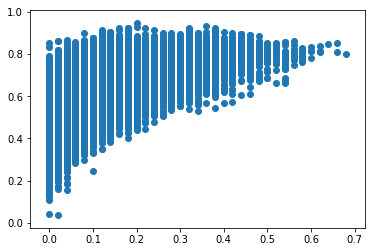

In [42]:
plt.scatter(Real_shifts['T1919_Jaccard'], Real_shifts['T1919_NDCG'])